In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

/mnt/weird_vol/miniconda/envs/downstr/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Engine

## Tau leaping algorithm

Tau leaping modifies the Gillespie methodology, it sacrifices exact simulation in favour of an approximate simulation that is quicker to compute.

It "flips" the logic:
- Instead of generating another poisson-process-reaction using the exponential distribution and then assigning this reaction to one of the possible reactions based on calculated probabilities, it leaps a certain amount of time into the future and asks how many reactions occured meanwhile of each type. The number of reactions are now poisson-distributed and thereby we can count them.

1. Initialize - Set initial conditions for the system and set leaping size
2. Calculate event rates - for each event types depending on state of the system
3. Monte-Carlo - for each event type sample number of events occuring within the leap
4. Update - Update system state based on number of events
5. Repeat - Repeat steps 2-4 until some stopping criteria is met


## Poisson distribution

The reactions occur as a poisson process - as a result the number of reactions occuring within a given timeframe will follow a poisson distribution.\
The waiting time between reactions follows an exponential distribution (this is used in the Gillespie simulation).

In [2]:
def pois_random_variable(rate):
    """
    Drawing will be done through the Inverse Transform sampling Method.
    So we want to find a number x for which FX(x) = U; where X is a 
    random variable (Poisson variable in this case) and U is a 
    uniform random variable and FX its distribution function 
    (Poisson distribution in this case). So this means that to find x
    (the goal of this whole function) we need to solve for $x = F^{(-1)}_x(U)$.

    So the steps are:
    - calculate the inverse of the Poisson CDF: $F^{(-1)}_x$
        - the inverse of a CDF can also be interpreted as its quantile function.
    - draw a uniform random probability U (from the interval [0,1], of course)
    - calculate $x = F^{(-1)}_x(U)$

    Note that for for the Poisson distribution, the quantile function is not defined 
    in closed form, so it must be calculated numerically.
    
    Given this, here we use scipy implementation of the ppf (quantile).

    Parameters
    ----------
    rate : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    u = np.random.random()
    return stats.poisson.ppf(u, rate)

## Simulation engine

In [4]:
def tau_leaping_simulation(L, T, LT, k_bind, k_dissociate, cycles, steps, leap):
    for i in tqdm(range(cycles)):
        for j in range(steps):
            # Calculate partial reaction rates
            r_bind = k_bind * L[i, j] * T[i, j]
            r_dissociate = k_dissociate * LT[i, j]

            # Calculate number of reactions by type
            n_bind = pois_random_variable(rate=r_bind * leap)
            n_dissociate = pois_random_variable(rate=r_dissociate * leap)

            # Apply limits to prevent negative population
            limit_bind = min(L[i,j], T[i,j])
            limit_dissociate = LT[i,j]
            
            n_bind = min(n_bind, limit_bind)
            n_dissociate = min(n_dissociate, limit_dissociate)
            
            # Update populations
            L[i, j+1] = L[i, j] + n_dissociate - n_bind
            T[i, j+1] = T[i, j] + n_dissociate - n_bind
            LT[i, j+1] = LT[i, j] + n_bind - n_dissociate
                
    return L, T, LT


# Simulate with physiological constants

In [39]:
# Fix random seed for repeatability
np.random.seed(1)

# Fix model parameters
k_bind = 0.0146  # Forward reaction rate
k_dissociate = 35  # Backwards reaction rate

L0 = 10000  # Initial number of ligands
T0 = 7000  # Initial number of receptors
LT0 = 0  # Initial number of ligands bound to receptors

leap = 0.000035 # Size of leaping steps
steps = 1000  # Number of leaps per trajectory
cycles = 100  # Number of trajectories iterated over
# I chose those numbers of leap and steps to match the total timespan of the 
# Gillespie's algorithm notebook (0 to 0.035)

# Set up holder arrays
t = np.arange(steps + 1) * leap
L = np.zeros((cycles, steps + 1))
T = np.zeros((cycles, steps + 1))
LT = np.zeros((cycles, steps + 1))

# Store initial conditions
L[:, 0] = L0
T[:, 0] = T0
LT[:, 0] = LT0

In [40]:
L, T, LT = tau_leaping_simulation(L=L, T=T, LT=LT, k_bind=k_bind, k_dissociate=k_dissociate, cycles=cycles, steps=steps, leap=leap)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.83it/s]


# Plot Average trajectory

In [41]:
# Set up average arrays
L_ave = L.mean(axis=0)
T_ave = T.mean(axis=0)
LT_ave = LT.mean(axis=0)

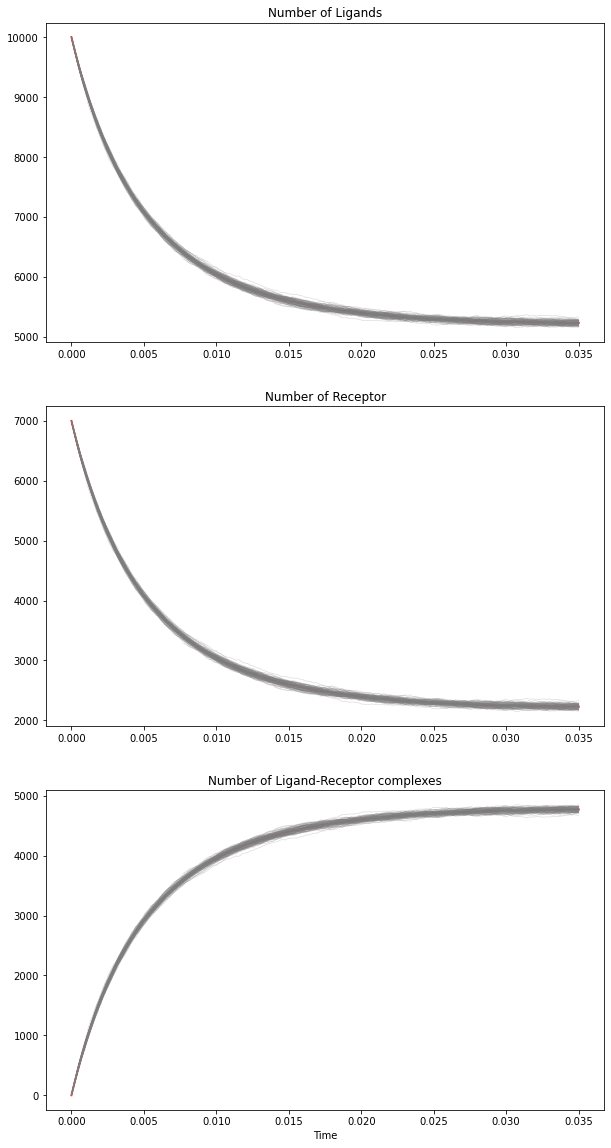

In [42]:
###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(10,20))

# Plot average trajectories
axs[0].plot(t, L_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number of Ligands')

axs[1].plot(t, T_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number of Receptor')

axs[2].plot(t, LT_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number of Ligand-Receptor complexes')
axs[2].set_xlabel("Time")

# Plot each simulated trajectory
for i in range(cycles):
    axs[0].plot(t[:], L[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1].plot(t[:], T[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[2].plot(t[:], LT[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)

Notes:
- Very very similar results
- Not easy to see but the average line should be smoother than using the Gillespie
- Each individual cycle is not as "organic": lines jump from one leap to the next
- Tau leaping algorithm was faster (11s vs 43s)

# Snapshot of molecule distribution of each type at a certain time

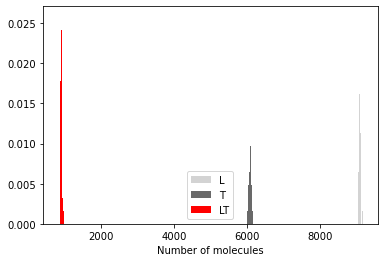

In [44]:
time = 0.001
L_time = np.zeros(cycles)
T_time = np.zeros(cycles)
LT_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if t[j] >= time and t[j-1] < time:
            L_time[i] = L[i,j]
            T_time[i] = T[i,j]
            LT_time[i] = LT[i,j]
    # If trajectory doesn't span far enough take latest observation
    if t[steps] < time:
        L_time[i] = L[i, steps]
        T_time[i] = T[i, steps]
        LT_time[i] = LT[i, steps]

plt.hist(L_time, density=True, bins=int(cycles/4), label="L", color='lightgrey')
plt.hist(T_time, density=True, bins=int(cycles/4), label="T", color='dimgrey')
plt.hist(LT_time, density=True, bins=int(cycles/4), label="LT", color='red')
plt.xlabel("Number of molecules")
plt.legend();

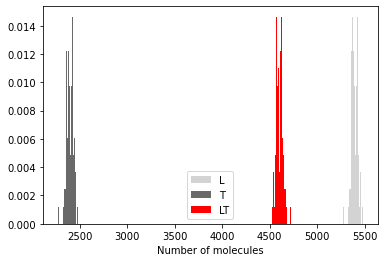

In [45]:
time = 0.02
L_time = np.zeros(cycles)
T_time = np.zeros(cycles)
LT_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if t[j] >= time and t[j-1] < time:
            L_time[i] = L[i,j]
            T_time[i] = T[i,j]
            LT_time[i] = LT[i,j]
    # If trajectory doesn't span far enough take latest observation
    if t[steps] < time:
        L_time[i] = L[i, steps]
        T_time[i] = T[i, steps]
        LT_time[i] = LT[i, steps]

plt.hist(L_time, density=True, bins=int(cycles/4), label="L", color='lightgrey')
plt.hist(T_time, density=True, bins=int(cycles/4), label="T", color='dimgrey')
plt.hist(LT_time, density=True, bins=int(cycles/4), label="LT", color='red')
plt.xlabel("Number of molecules")
plt.legend();

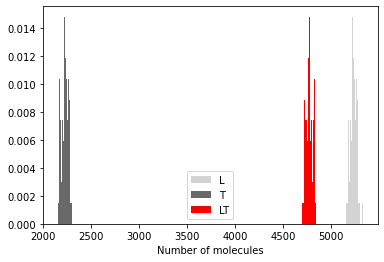

In [46]:
time = 0.035
L_time = np.zeros(cycles)
T_time = np.zeros(cycles)
LT_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if t[j] >= time and t[j-1] < time:
            L_time[i] = L[i,j]
            T_time[i] = T[i,j]
            LT_time[i] = LT[i,j]
    # If trajectory doesn't span far enough take latest observation
    if t[steps] < time:
        L_time[i] = L[i, steps]
        T_time[i] = T[i, steps]
        LT_time[i] = LT[i, steps]

plt.hist(L_time, density=True, bins=int(cycles/4), label="L", color='lightgrey')
plt.hist(T_time, density=True, bins=int(cycles/4), label="T", color='dimgrey')
plt.hist(LT_time, density=True, bins=int(cycles/4), label="LT", color='red')
plt.xlabel("Number of molecules")
plt.legend();

# Plot just one cycle, but for much longer

In [53]:
# Fix random seed for repeatability
np.random.seed(1)

# Fix model parameters
k_bind = 0.0146  # Forward reaction rate
k_dissociate = 35  # Backwards reaction rate

L0 = 10000  # Initial number of ligands
T0 = 7000  # Initial number of receptors
LT0 = 0  # Initial number of ligands bound to receptors

leap = 0.0012 # Size of leaping steps
steps = 1000  # Number of leaps per trajectory
cycles = 1  # Number of trajectories iterated over
# I chose those numbers of leap and steps to match the total timespan of the 
# Gillespie's algorithm notebook (0 to 1.2)

# Set up holder arrays
t = np.arange(steps + 1) * leap
L = np.zeros((cycles, steps + 1))
T = np.zeros((cycles, steps + 1))
LT = np.zeros((cycles, steps + 1))

# Store initial conditions
L[:, 0] = L0
T[:, 0] = T0
LT[:, 0] = LT0

In [54]:
L, T, LT = tau_leaping_simulation(L=L, T=T, LT=LT, k_bind=k_bind, k_dissociate=k_dissociate, cycles=cycles, steps=steps, leap=leap)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


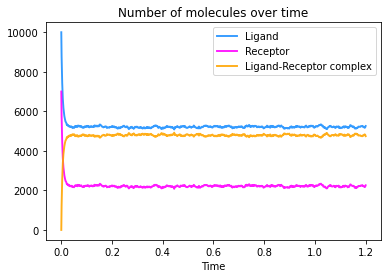

In [55]:
###### Plot Trajectories ######
# Plot average trajectories
plt.plot(t.flatten(), L.flatten(), marker='', color='dodgerblue', linewidth=1.9, alpha=0.9, label="Ligand")

plt.plot(t.flatten(), T.flatten(), marker='', color='magenta', linewidth=1.9, alpha=0.9, label="Receptor")

plt.plot(t.flatten(), LT.flatten(), marker='', color='orange', linewidth=1.9, alpha=0.9, label="Ligand-Receptor complex")
plt.title('Number of molecules over time')
plt.legend()
plt.xlabel("Time");


Notes:
- It's basically the same plot as using the Gillespie's algorithm
- But faster

100%|██████████| 1/1 [00:00<00:00, 68.42it/s]


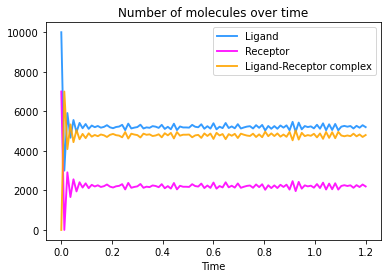

In [56]:
# Fix random seed for repeatability
np.random.seed(1)

# Fix model parameters
k_bind = 0.0146  # Forward reaction rate
k_dissociate = 35  # Backwards reaction rate

L0 = 10000  # Initial number of ligands
T0 = 7000  # Initial number of receptors
LT0 = 0  # Initial number of ligands bound to receptors

leap = 0.012 # Size of leaping steps
steps = 100  # Number of leaps per trajectory
cycles = 1  # Number of trajectories iterated over
# I chose those numbers of leap and steps to match the total timespan of the 
# Gillespie's algorithm notebook (0 to 1.2)

# Set up holder arrays
t = np.arange(steps + 1) * leap
L = np.zeros((cycles, steps + 1))
T = np.zeros((cycles, steps + 1))
LT = np.zeros((cycles, steps + 1))

# Store initial conditions
L[:, 0] = L0
T[:, 0] = T0
LT[:, 0] = LT0

###### Run the algorithm ######
L, T, LT = tau_leaping_simulation(L=L, T=T, LT=LT, k_bind=k_bind, k_dissociate=k_dissociate, cycles=cycles, steps=steps, leap=leap)

###### Plot Trajectories ######
# Plot average trajectories
plt.plot(t.flatten(), L.flatten(), marker='', color='dodgerblue', linewidth=1.9, alpha=0.9, label="Ligand")

plt.plot(t.flatten(), T.flatten(), marker='', color='magenta', linewidth=1.9, alpha=0.9, label="Receptor")

plt.plot(t.flatten(), LT.flatten(), marker='', color='orange', linewidth=1.9, alpha=0.9, label="Ligand-Receptor complex")
plt.title('Number of molecules over time')
plt.legend()
plt.xlabel("Time");

Notes:
- When reducing the number of steps and increasing the leap size, we see that we increase the noise/instability of the predictions
- But this would allow us to cover even longer timespans in much much less time than using Gillespie's